In [1]:
import numpy as np
from collections import defaultdict
import math
import copy
import matplotlib.pyplot as plt
%matplotlib inline

## Example 9.1 - MC gradient with state aggregate on 1000 state random walk

In [2]:
class DPAgent():
    '''
    Params:
        actions: a dictionary mapping states to allowed actions
        states: a list of states
        transition_table: a dictionary mapping a tuple of (state, action) to a list of (p(s', r), s', r)
    '''
    def __init__(self, states, actions, transition_table, discount_factor):
        self.states = states
        self.actions = actions
        self.transition_table = transition_table
        # start with stochastic policy
        self.policy = {}
        for state in states:
            self.policy[state] = [(action, 1/len(self.actions[state])) for action in self.actions[state]]
        self.V = defaultdict(lambda : 0)
        self.discount_factor = discount_factor
    
    def evaluate_policy(self, threshold, verbose=False):
        while True:
            delta = 0
            oldV = copy.deepcopy(self.V)
            for state in self.states:
                v = self.V[state]
                newV = 0
                for action, prob in self.policy[state]:
                    for transition, next_state, reward in self.transition_table[(state, action)]:
                        newV += prob * transition * (reward + self.discount_factor * oldV[next_state])
                self.V[state] = newV
                delta = max(delta, abs(v - self.V[state]))
            if verbose:
                print(self.V)
            if delta < threshold:
                break
                
    def improve_policy(self):
        did_change = False
        for state in self.states:
            best_action = None
            best_value = -1000
            for action in self.actions[state]:
                action_value = 0
                for transition, next_state, reward in self.transition_table[(state, action)]:
                    action_value += transition * (reward + self.discount_factor * self.V[next_state])
                    if action_value > best_value:
                        best_action = action
                        best_value = action_value
            newPolicy = [(action, 1) if action == best_action else (action, 0) for action in self.actions[state]]
            if not all([na == oa and nv == ov for (na, nv), (oa, ov) in zip(newPolicy, self.policy[state])]):
                did_change = True
            self.policy[state] = newPolicy
        return did_change
            
                
    def iterate_policy(self):
        did_change = True
        while did_change:
            self.evaluate_policy(1e-10)
            did_change = self.improve_policy()
        

In [158]:
class RandomWalk:
    """
    env will be an interface with the following methods:
    start: return a starting state
    act: takes in an action and return next_state, reward, is_end
    it should also have a class variable for actions allowed
    """
    actions = ['l', 'r']
    
    def __init__(self, no_of_states = 19):
        self.no_of_states = no_of_states
        self.start_state = int(self.no_of_states/2)
        self.states = range(no_of_states) # last state is dummy
        self.actions_per_state = defaultdict(lambda : ['l', 'r'])
        self.transition_table = defaultdict(list)
        for state in self.states:
            for action in self.actions_per_state[state]:
                # use dummy state
                running_prob = 0
                if action == 'r':
                    for i in range(1, min(101, no_of_states - state + 1)):
                        next_state = state + i
                        if i == 100 or next_state == no_of_states:
                            prob = 1 - running_prob
                            self.transition_table[state, action].append((prob, next_state, 1))
                        else:
                            prob = 1/100
                            running_prob += prob
                            self.transition_table[state, action].append((prob, next_state, 0))
    
                if action == 'l':
                    for i in range(1, min(101, state + 2)):
                        next_state = state - i
                        if i == 100 or next_state == -1:
                            prob = 1 - running_prob
                            self.transition_table[state, action].append((prob, next_state, -1))
                        else:
                            prob = 1/100
                            running_prob += prob
                            self.transition_table[state, action].append((prob, next_state, 0))
    def start(self):
        self.state = self.start_state
        return self.state
    
    def act(self, action):
        move = np.random.randint(1, 101)
        if action == 'l':
            next_state = self.state - move
            if next_state < 0:
                self.state = 0
                return self.state, -1, True
            else:
                self.state = next_state
                return self.state, 0, False
        else:
            next_state = self.state + move
            if next_state >= self.no_of_states:
                self.state = self.no_of_states - 1
                return self.state, 1, True
            else:
                self.state = next_state
                return self.state, 0, False

In [159]:
randomwalk_env = RandomWalk(1000)

In [160]:
random_walk_dp_agent = DPAgent(randomwalk_env.states, randomwalk_env.actions_per_state, randomwalk_env.transition_table, 1)

In [161]:
random_walk_dp_agent.evaluate_policy(1e-10)

In [162]:
actual_v = np.array([random_walk_dp_agent.V[state] for state in range(1000)])

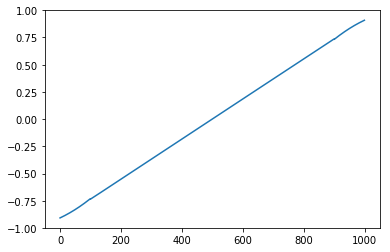

In [163]:
plt.plot(range(1000), actual_v)

In [152]:
class LinearGMC():
    def __init__(self, env, alpha, policy, feature_length, state_function, gamma=1):
        # state_function maps a state to a state feature vector
        self.env = env
        self.actions = env.actions
        self.alpha = alpha
        self.policy = policy # policy is a function
        self.state_function = state_function
        self.gamma = gamma
        self.theta = np.zeros(feature_length)
        self.state_count = defaultdict(int)
        
    def evaluate(self, episodes):
        for i in range(episodes):
            episode = []
            state = self.env.start()
            is_end = False
            while not is_end:
                self.state_count[state] += 1
                action = self.policy(state)
                next_state, reward, is_end = self.env.act(action)
                episode.append((state, reward, next_state))
                state = next_state
            G = 0
            for state, reward, _ in episode[::-1]:
                G = self.gamma * G + reward
                feature = self.state_function(state)
                self.theta += self.alpha * (G - np.dot(feature, self.theta)) * feature # linear fn means grad is just feature vector
        

In [153]:
def state_aggregation(state):
    vector = np.zeros(10)
    vector[state//100] = 1
    return vector

In [154]:
lineargmc = LinearGMC(randomwalk_env, 2e-5, lambda _:np.random.choice(['l','r']), 10, state_aggregation)

In [155]:
lineargmc.evaluate(100000)

In [156]:
learned_v = [lineargmc.theta[i//100] for i in range(1000)]

In [173]:
total = np.sum(list(lineargmc.state_count.values()))
state_dist = [lineargmc.state_count[state]/total for state in range(1000)]

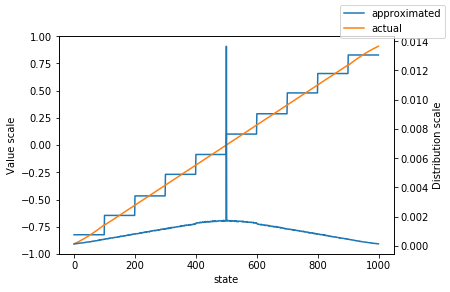

In [181]:
fig, ax1 = plt.subplots()
ax1.plot(range(1000), learned_v, label='approximated')
ax1.plot(range(1000), actual_v, label='actual')
ax1.set_ylabel('Value scale')
ax1.set_xlabel('state')
ax2 = ax1.twinx()
ax2.plot(range(1000),state_dist)
ax2.set_ylabel('Distribution scale')
fig.legend()

In [187]:
class LinearTD():
    def __init__(self, env, alpha, policy, feature_length, state_function, gamma=1):
        # state_function maps a state to a state feature vector
        self.env = env
        self.actions = env.actions
        self.alpha = alpha
        self.policy = policy # policy is a function
        self.state_function = state_function
        self.gamma = gamma
        self.theta = np.zeros(feature_length)
        
    def evaluate(self, episodes):
        for i in range(episodes):
            episode = []
            state = self.env.start()
            is_end = False
            while not is_end:
                action = self.policy(state)
                next_state, reward, is_end = self.env.act(action)
                feature = self.state_function(state)
                next_feature = self.state_function(next_state)
                self.theta += self.alpha * (reward + self.gamma * np.dot(next_feature, self.theta) - np.dot(feature, self.theta)) * feature # linear fn means grad is just feature vector
                state = next_state
        

In [197]:
lineartd = LinearTD(randomwalk_env, 2e-5, lambda _ : np.random.choice(['l', 'r']), 10, state_aggregation)

In [198]:
lineartd.evaluate(500000)

In [199]:
tdv = [lineartd.theta[i//100] for i in range(1000)]

Text(0.5,0,'state')

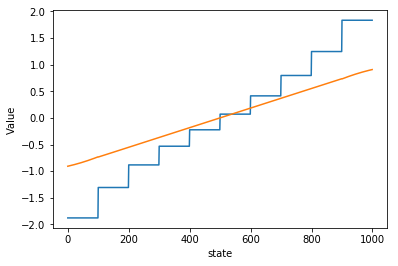

In [200]:
plt.plot(range(1000), tdv, label='approximated with TD(0)')
plt.plot(range(1000), actual_v, label='actual')
plt.ylabel('Value')
plt.xlabel('state')

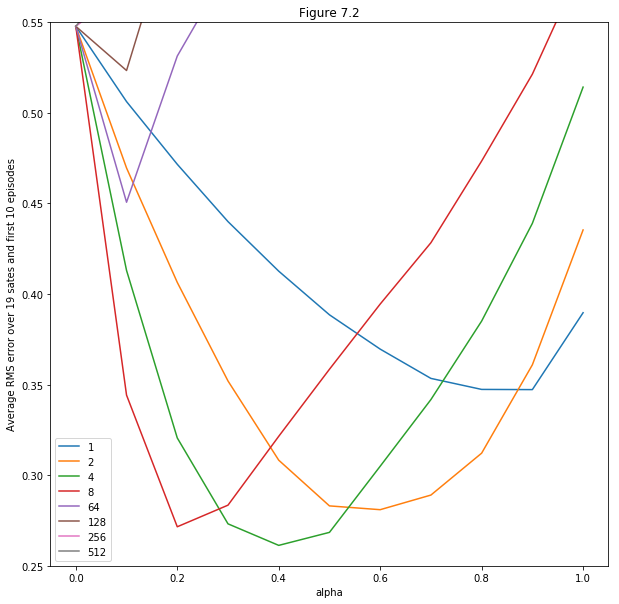

In [72]:
plt.figure(figsize=(10,10))
for n, errors in alpha_error.items():
    plt.plot(*zip(*errors), label=n)
plt.ylabel('Average RMS error over 19 sates and first 10 episodes')
plt.xlabel('alpha')
plt.title('Figure 7.2')
plt.ylim(0.25, 0.55)
plt.legend()